Stacking Regressor Performance:
RMSE: 30470.114719084424
R^2 Score: 0.8789584867819279


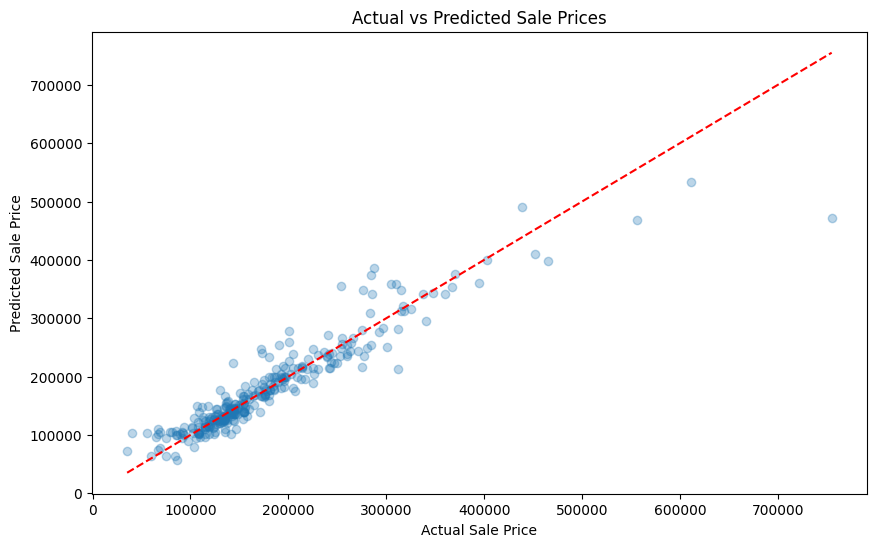

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('train.csv')

# Handle missing values
df = df[df.columns[df.isnull().mean() < 0.5]]  # Drop columns with >50% missing values

num_features = df.select_dtypes(include=[np.number]).columns
cat_features = df.select_dtypes(include=[object]).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# Feature Engineering
df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = df['YrSold'] - df['YearBuilt']
df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)

# One-Hot Encoding
df = pd.get_dummies(df, columns=['Neighborhood', 'ExterQual', 'KitchenQual'], drop_first=True)

# Define features and target
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBathrooms', 'TotalSF', 'Age', 'IsRemodeled']
selected_features.extend([col for col in df.columns if col.startswith(('Neighborhood_', 'ExterQual_', 'KitchenQual_'))])

X = df[selected_features]
y = df['SalePrice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
ridge = Ridge()
lasso = Lasso()
gbr = GradientBoostingRegressor()
xgbr = XGBRegressor()
lgbmr = lgb.LGBMRegressor(verbose=-1)  # Suppress LightGBM warnings

# Hyperparameter tuning
ridge_grid = GridSearchCV(ridge, {'alpha': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_

lasso_grid = GridSearchCV(lasso, {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)
best_lasso = lasso_grid.best_estimator_

gbr_params = {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]}
gbr_grid = GridSearchCV(gbr, gbr_params, cv=5, scoring='neg_mean_squared_error')
gbr_grid.fit(X_train, y_train)
best_gbr = gbr_grid.best_estimator_

xgbr_params = {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]}
xgbr_grid = GridSearchCV(xgbr, xgbr_params, cv=5, scoring='neg_mean_squared_error')
xgbr_grid.fit(X_train, y_train)
best_xgbr = xgbr_grid.best_estimator_

lgbmr_params = {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5], 'verbose': [-1]}
lgbmr_grid = GridSearchCV(lgbmr, lgbmr_params, cv=5, scoring='neg_mean_squared_error')
lgbmr_grid.fit(X_train, y_train)
best_lgbmr = lgbmr_grid.best_estimator_

# Stacking model
estimators = [('ridge', best_ridge), ('lasso', best_lasso), ('gbr', best_gbr), ('xgbr', best_xgbr), ('lgbmr', best_lgbmr)]
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

# Train stacking model
stacking_regressor.fit(X_train_scaled, y_train)

# Predictions
y_pred = stacking_regressor.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Stacking Regressor Performance:")
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.show()


In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.8 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.0 MB/s eta 0:00:00
